# Image transformations

This notebook shows new features of torchvision image transformations:
- can accept torch tensor images as input
- can run on GPU
- can be torch jit scripted (except `Compose`, `RandomApply`, `RandomChoice`, `Lambda` transforms).
- can be applied on batch of tensors


In [ ]:
# TO REMOVE ONCE v0.8.0 RELEASED

# pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html

!pip uninstall -y -q torchvision
!pip install --pre -q --upgrade torch -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html
!git clone https://github.com/pytorch/vision.git
!cd vision && python setup.py develop > /dev/null

# restart runtime: ctrl/cmd+m+,

In [1]:
import torch, torchvision
torch.__version__, torchvision.__version__

('1.7.0.dev20201001+cu101', '0.8.0a0+6b41eb0')

## Transforms on CPU/CUDA tensor images

Let's show how to apply transformations on image opened as a tensor 

In [29]:
!wget https://farm1.static.flickr.com/152/434505223_8d1890e1e2.jpg -q -Otest-image.jpg
!wget https://farm3.static.flickr.com/2142/1896267403_24939864ba.jpg -q -Otest-image2.jpg

In [30]:
import matplotlib.pylab as plt
%matplotlib inline

tensor image info:  torch.Size([3, 323, 500]) torch.uint8


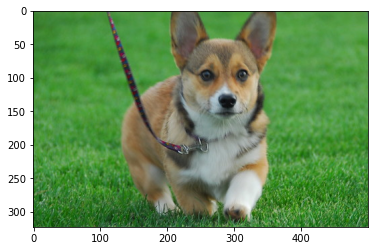

In [31]:
from torchvision.io.image import read_image

tensor_image = read_image("test-image.jpg")

print("tensor image info: ", tensor_image.shape, tensor_image.dtype)

plt.imshow(tensor_image.numpy().transpose((1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


output tensor image info:  torch.Size([3, 224, 224]) torch.float32


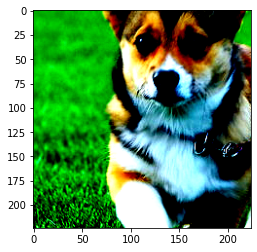

In [32]:
import torchvision.transforms as T

# to fix random seed is now:
torch.manual_seed(12)

transforms = T.Compose([
    T.RandomCrop(224),
    T.RandomHorizontalFlip(),
    T.ConvertImageDtype(torch.float),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

out_image = transforms(tensor_image)
print("output tensor image info: ", out_image.shape, out_image.dtype)

plt.imshow(out_image.numpy().transpose((1, 2, 0)))

Tensor images can be on GPU

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


output tensor image info:  torch.Size([3, 196, 196]) torch.float32 cuda:0


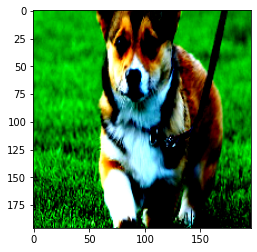

In [33]:
import torchvision.transforms as T

# to fix random seed is now:
torch.manual_seed(12)

transforms = T.Compose([
    T.Resize(256),
    T.RandomCrop(196),
    T.RandomHorizontalFlip(),
    T.ConvertImageDtype(torch.float),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

out_image = transforms(tensor_image.to("cuda"))
print("output tensor image info: ", out_image.shape, out_image.dtype, out_image.device)

plt.imshow(out_image.cpu().numpy().transpose((1, 2, 0)))

## Scripted transforms

### Inference example

Next, we show how to combine input transformations and model's forward pass and use `torch.jit.script` to obtain a single scripted module.

**Note:** we have to use only scriptable transformations. All transformations are scriptable except `Compose`, `RandomApply`, `RandomChoice`, `Lambda` and those applied on PIL images. Therefore, we have to replace `T.Compose` by `nn.Sequential`.

Let's define a module `Predictor` that transforms input tensor and applies ImageNet pretrained resnet18 model on it.

In [34]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.io.image import read_image
from torchvision.models import resnet18


class Predictor(nn.Module):

    def __init__(self):
        super().__init__()
        self.resnet18 = resnet18(pretrained=True).eval()
        self.transforms = nn.Sequential(
            T.Resize(256),
            T.CenterCrop(224),
            T.ConvertImageDtype(torch.float),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        )

    @torch.no_grad()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.transforms(x)
        y_pred = self.resnet18(x)
        return y_pred.argmax(dim=1)

Now, let's define scripted and non-scripted instances of `Predictor` and apply on multiple tensor images of the same size

In [37]:
from torchvision.io.image import read_image

predictor = Predictor().to("cuda")
scripted_predictor = torch.jit.script(predictor).to("cuda")


tensor_image1 = read_image("test-image.jpg")
tensor_image2 = read_image("test-image2.jpg")
batch = torch.stack([tensor_image1[:, -320:, :], tensor_image2[:, -320:, :]]).to("cuda")

res1 = scripted_predictor(batch)
res2 = predictor(batch)

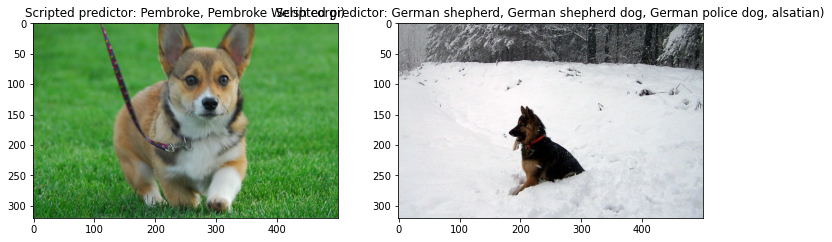

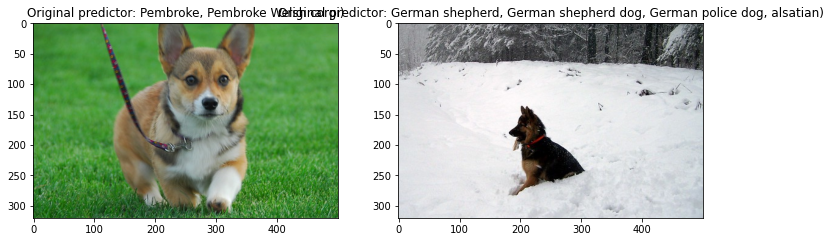

In [38]:
!wget https://raw.githubusercontent.com/lukemelas/EfficientNet-PyTorch/master/examples/simple/labels_map.txt -q -O/tmp/labels_map.txt

import json

with open("/tmp/labels_map.txt", "r") as h:
    labels = json.load(h)



plt.figure(figsize=(12, 7))
for i, p in enumerate(res1):
    plt.subplot(1, 2, i + 1)
    plt.title("Scripted predictor: {label})".format(label=labels[str(p.item())]))
    plt.imshow(batch[i, ...].cpu().numpy().transpose((1, 2, 0)))


plt.figure(figsize=(12, 7))
for i, p in enumerate(res2):
    plt.subplot(1, 2, i + 1)
    plt.title("Original predictor: {label})".format(label=labels[str(p.item())]))
    plt.imshow(batch[i, ...].cpu().numpy().transpose((1, 2, 0)))

We save and reload scripted predictor in Python or C++ and use it for inference:

In [39]:
scripted_predictor.save("scripted_predictor.pt")

scripted_predictor = torch.jit.load("scripted_predictor.pt")
res1 = scripted_predictor(batch)

for i, p in enumerate(res1):
    print("Scripted predictor: {label})".format(label=labels[str(p.item())]))


Scripted predictor: Pembroke, Pembroke Welsh corgi)
Scripted predictor: German shepherd, German shepherd dog, German police dog, alsatian)


## Transforms on tensors for video input

TODO